In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("application_train.csv")
test_df = pd.read_csv("application_test.csv")

In [3]:
print(f"Датафрейм для тренування має форму {train_df.shape}")
train_df.head()

Датафрейм для тренування має форму (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(f"Датафрейм для тестування має форму {test_df.shape}")
test_df.head()

Датафрейм для тестування має форму (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
set(train_df.columns) - set(test_df.columns)

{'TARGET'}

Як бачимо, тренувальний набір даних містить 122 колонки, включно із TARGET, що є цільовою колонкою нашої задачі класифікації. Тренувальний набір містить 307511 записів та 120 фіч, якщо не включати ідентифікатор

### Розподіл цільової колонки

TARGET
0    0.919271
1    0.080729
Name: count, dtype: float64


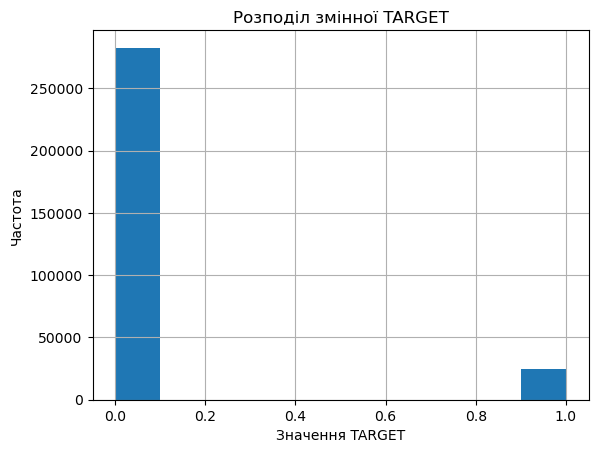

In [6]:
%matplotlib inline

target_dist = train_df['TARGET'].value_counts() / train_df['TARGET'].count()
print(target_dist)

train_df['TARGET'].astype(int).plot.hist()
plt.title("Розподіл змінної TARGET")
plt.xlabel("Значення TARGET")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

Розподіл змінної є незбалансованим саме у бік значення 0: більше 90% значень належить до одного класу, через що у моделі може бути "упереджене" ставлення до більш популярного класу 

### Аналіз відсутніх значень

In [7]:
def missing_values_df(df: pd.DataFrame):
    mis_val = df.isnull().sum()
    mis_val_share = 100 * mis_val / len(df)
    mis_val_df = pd.concat([mis_val, mis_val_share], axis=1)
    
    mis_val_df = mis_val_df.rename(columns={0: 'Missing Values', 1: 'Share of total values'})
    mis_val_df = mis_val_df[mis_val_df.iloc[:, 1] != 0].sort_values('Share of total values', ascending=False).round(2)
    
    print(f"Датафрейм має {df.shape[1]} колонок, з яких {mis_val_df.shape[0]} містять відсутні значення.")
    
    return mis_val_df

In [8]:
train_missing_df = missing_values_df(train_df)
test_missing_df = missing_values_df(test_df)
train_missing_df.head(20)

Датафрейм має 122 колонок, з яких 67 містять відсутні значення.
Датафрейм має 121 колонок, з яких 64 містять відсутні значення.


,Missing Values,Share of total values
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35


Досить багато стовпців мають пропущені дані, доволі багато мають більшість таких значень

### Типи значень колонок

In [9]:
train_df.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

У тих колонок, де значення мають тип object (скоріше за все str), категоріальний зміст. Подивимось кількість класів по кожній категоріальній змінній 

In [10]:
unique_counts = train_df.select_dtypes('object').apply(pd.Series.nunique)
unique_counts

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Окрім цього з файлу з описами фіч можна знайти, що колонки, які мають FLAG на початку, також є категоріальними, хоч і не містять даних типу object

In [11]:
categorical =   unique_counts.index.to_list() + \
                train_df.filter(like='FLAG').columns.tolist() + \
                train_df.filter(like='REG').columns.tolist() + \
                train_df.filter(like='LIVE').columns.tolist()

categorical

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIE

Позначимо решту колонок як числові

In [12]:
numerical = list(set(train_df.columns) - set(categorical))
numerical.remove('SK_ID_CURR')
numerical

['COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'ELEVATORS_AVG',
 'LANDAREA_AVG',
 'DAYS_EMPLOYED',
 'NONLIVINGAREA_MODE',
 'COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'ENTRANCES_MODE',
 'BASEMENTAREA_MODE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'FLOORSMIN_MEDI',
 'HOUR_APPR_PROCESS_START',
 'COMMONAREA_MODE',
 'APARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'DAYS_ID_PUBLISH',
 'YEARS_BEGINEXPLUATATION_MODE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'DAYS_BIRTH',
 'EXT_SOURCE_3',
 'YEARS_BUILD_AVG',
 'ELEVATORS_MODE',
 'AMT_ANNUITY',
 'FLOORSMAX_AVG',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'FLOORSMIN_MODE',
 'FLOORSMAX_MODE',
 'EXT_SOURCE_2',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'EXT_SOURCE_1',
 'FLOORSMAX_MEDI',
 'DAYS_LAST_PHONE_CHANGE',
 'YEARS_BUILD_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'LANDAREA_MEDI',
 'TARGET',
 'LIVINGAPARTMENTS_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_INCOME_TOTAL',
 'ELEVATORS_ME

### Розподіл чисельних та категоріальних стовпців

In [13]:
train_df[numerical].describe()

,COMMONAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,ELEVATORS_AVG,LANDAREA_AVG,DAYS_EMPLOYED,NONLIVINGAREA_MODE,COMMONAREA_AVG,LIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,ENTRANCES_MODE,...,TOTALAREA_MODE,NONLIVINGAPARTMENTS_AVG,BASEMENTAREA_MEDI,YEARS_BUILD_MEDI,YEARS_BEGINEXPLUATATION_MEDI,LIVINGAREA_AVG,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,APARTMENTS_MEDI,AMT_CREDIT
count,92646.000000,93997.000000,143620.000000,124921.000000,307511.000000,137829.000000,92646.000000,97312.000000,137829.000000,152683.000000,...,159080.000000,93997.000000,127568.000000,103023.000000,157504.000000,153161.000000,151450.00000,157504.000000,151450.000000,3.075110e+05
mean,0.044595,0.008651,0.078942,0.066333,63815.045904,0.027022,0.044621,0.100775,0.028358,0.145193,...,0.102547,0.008809,0.087955,0.755746,0.977752,0.107399,0.11744,0.977735,0.117850,5.990260e+05
std,0.076144,0.047415,0.134576,0.081184,141275.766519,0.070254,0.076036,0.092576,0.069523,0.100977,...,0.107462,0.047732,0.082179,0.112066,0.059897,0.110565,0.10824,0.059223,0.109076,4.024908e+05
min,0.000000,0.000000,0.000000,0.000000,-17912.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.500000e+04
25%,0.007900,0.000000,0.000000,0.018700,-2760.000000,0.000000,0.007800,0.050400,0.000000,0.069000,...,0.041200,0.000000,0.043700,0.691400,0.976700,0.045300,0.05770,0.976700,0.058300,2.700000e+05
50%,0.020800,0.000000,0.000000,0.048100,-1213.000000,0.001100,0.021100,0.075600,0.003600,0.137900,...,0.068800,0.000000,0.075800,0.758500,0.981600,0.074500,0.08760,0.981600,0.086400,5.135310e+05
75%,0.051300,0.003900,0.120000,0.085600,-289.000000,0.023100,0.051500,0.121000,0.027700,0.206900,...,0.127600,0.003900,0.111600,0.825600,0.986600,0.129900,0.14850,0.986600,0.148900,8.086500e+05
max,1.000000,1.000000,1.000000,1.000000,365243.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,4.050000e+06


In [14]:
train_df[categorical].describe()

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,...,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,0.000042,0.710023,0.000081,0.015115,...,2.031521,0.015144,0.050769,0.040659,0.078173,0.230454,0.015144,0.040659,0.078173,0.179555
std,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.006502,0.453752,0.009016,0.122010,...,0.502737,0.122126,0.219526,0.197499,0.268444,0.421124,0.122126,0.197499,0.268444,0.383817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Застосуємо Label Encoding для бінарних класів та One-Hot Encoding для класів з більше ніж двома класами

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in categorical:
    if len(list(train_df[col].unique())) <= 2:
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])

train_df_enc = pd.get_dummies(train_df)
test_df_enc = pd.get_dummies(test_df)

print(f"Форма тренувального датафрейму: {train_df_enc.shape}")
print(f"Форма тестувального датафрейму: {test_df_enc.shape}")

Форма тренувального датафрейму: (307511, 243)
Форма тестувального датафрейму: (48744, 239)


Виконаємо "вирівнювання" наборів даних для того, аби колонки у обох співпадали, при цьому збережемо цільову колонку і додамо вже після операції align

In [16]:
Y_train = train_df_enc['TARGET']
train_df, test_df = train_df_enc.align(test_df_enc, join='inner', axis=1)

train_df['TARGET'] = Y_train
print(f'Форма тренувального датафрейму: {train_df.shape}')
print(f'Форма тестувального датафрейму: {test_df.shape}')

Форма тренувального датафрейму: (307511, 240)
Форма тестувального датафрейму: (48744, 239)


Подивимось на кореляції колонок відносно змінної TARGET у тренувальному наборі даних і відсортуємо їх за спаданням

In [17]:
correlations = train_df.corr()['TARGET'].sort_values(ascending=False)

print('Найбільші позитивні кореляції:\n', correlations.head(15))
print('Найбільші негативні кореляції:\n', correlations.tail(15))

Найбільші позитивні кореляції:
 TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
DAYS_REGISTRATION                                    0.041975
Name: TARGET, dtype: float64
Найбільші

Бачимо, що DAYS_BIRTH, яка представляє вік клієнта у днях, має найбільшу позитивну кореляцію у 7.8%, у той час як найбільша негативна кореляція у змінних EXT_SOURCE_3, EXT_SOURCE_2 та EXT_SOURCE_1 відповідно, тобто чим більше значення цим колонок, тим більше ймовірність уплати клієнтом боргу.

### Викорінення аномалій

Оскільки колонки, що мають відношення до кількості днів, є відмінними, з них виділяється DAYS_EMPLOYED, яка має багато аномальних значень на рівні 365243, що можна побачити на гістограмі та подивитись розподіл даної колонки за допомогою value_counts

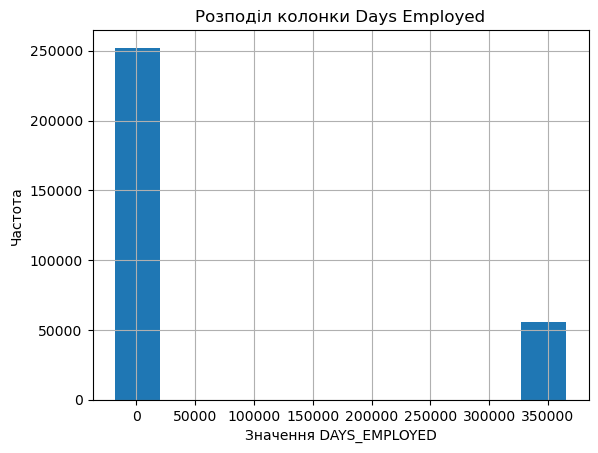

In [18]:
train_df['DAYS_EMPLOYED'].plot.hist(title='Розподіл колонки Days Employed')
plt.grid(True)
plt.xlabel('Значення DAYS_EMPLOYED')
plt.ylabel('Частота')
plt.show()

In [19]:
train_df[train_df['DAYS_EMPLOYED'] >= 300000]['DAYS_EMPLOYED'].value_counts()

DAYS_EMPLOYED
365243    55374
Name: count, dtype: int64

Для вирішення проблеми замінимо ці значення спочатку на NaN, а потім на середнє значення за цією колонкою, зробимо нову гістограму розподілу для DAYS_EMPLOYED

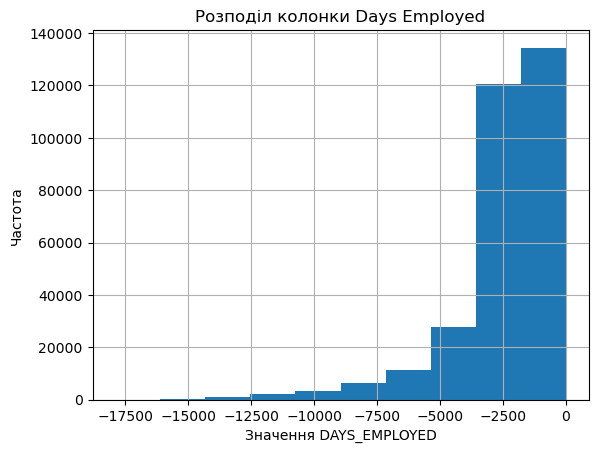

In [20]:
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
train_df['DAYS_EMPLOYED'].fillna(train_df['DAYS_EMPLOYED'].mean(), inplace=True)

train_df['DAYS_EMPLOYED'].plot.hist(title='Розподіл колонки Days Employed')
plt.grid(True)
plt.xlabel('Значення DAYS_EMPLOYED')
plt.ylabel('Частота')
plt.show()

Схоже, аномалій більше немає. Замінимо аномальні значення також і для тестового датафрейму

In [21]:
test_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
test_df['DAYS_EMPLOYED'].fillna(test_df['DAYS_EMPLOYED'].mean(), inplace=True)

In [22]:
numerical.remove("TARGET")

### Візуалізація числових колонок

Спочатку подивимось на розподіли числових колонок

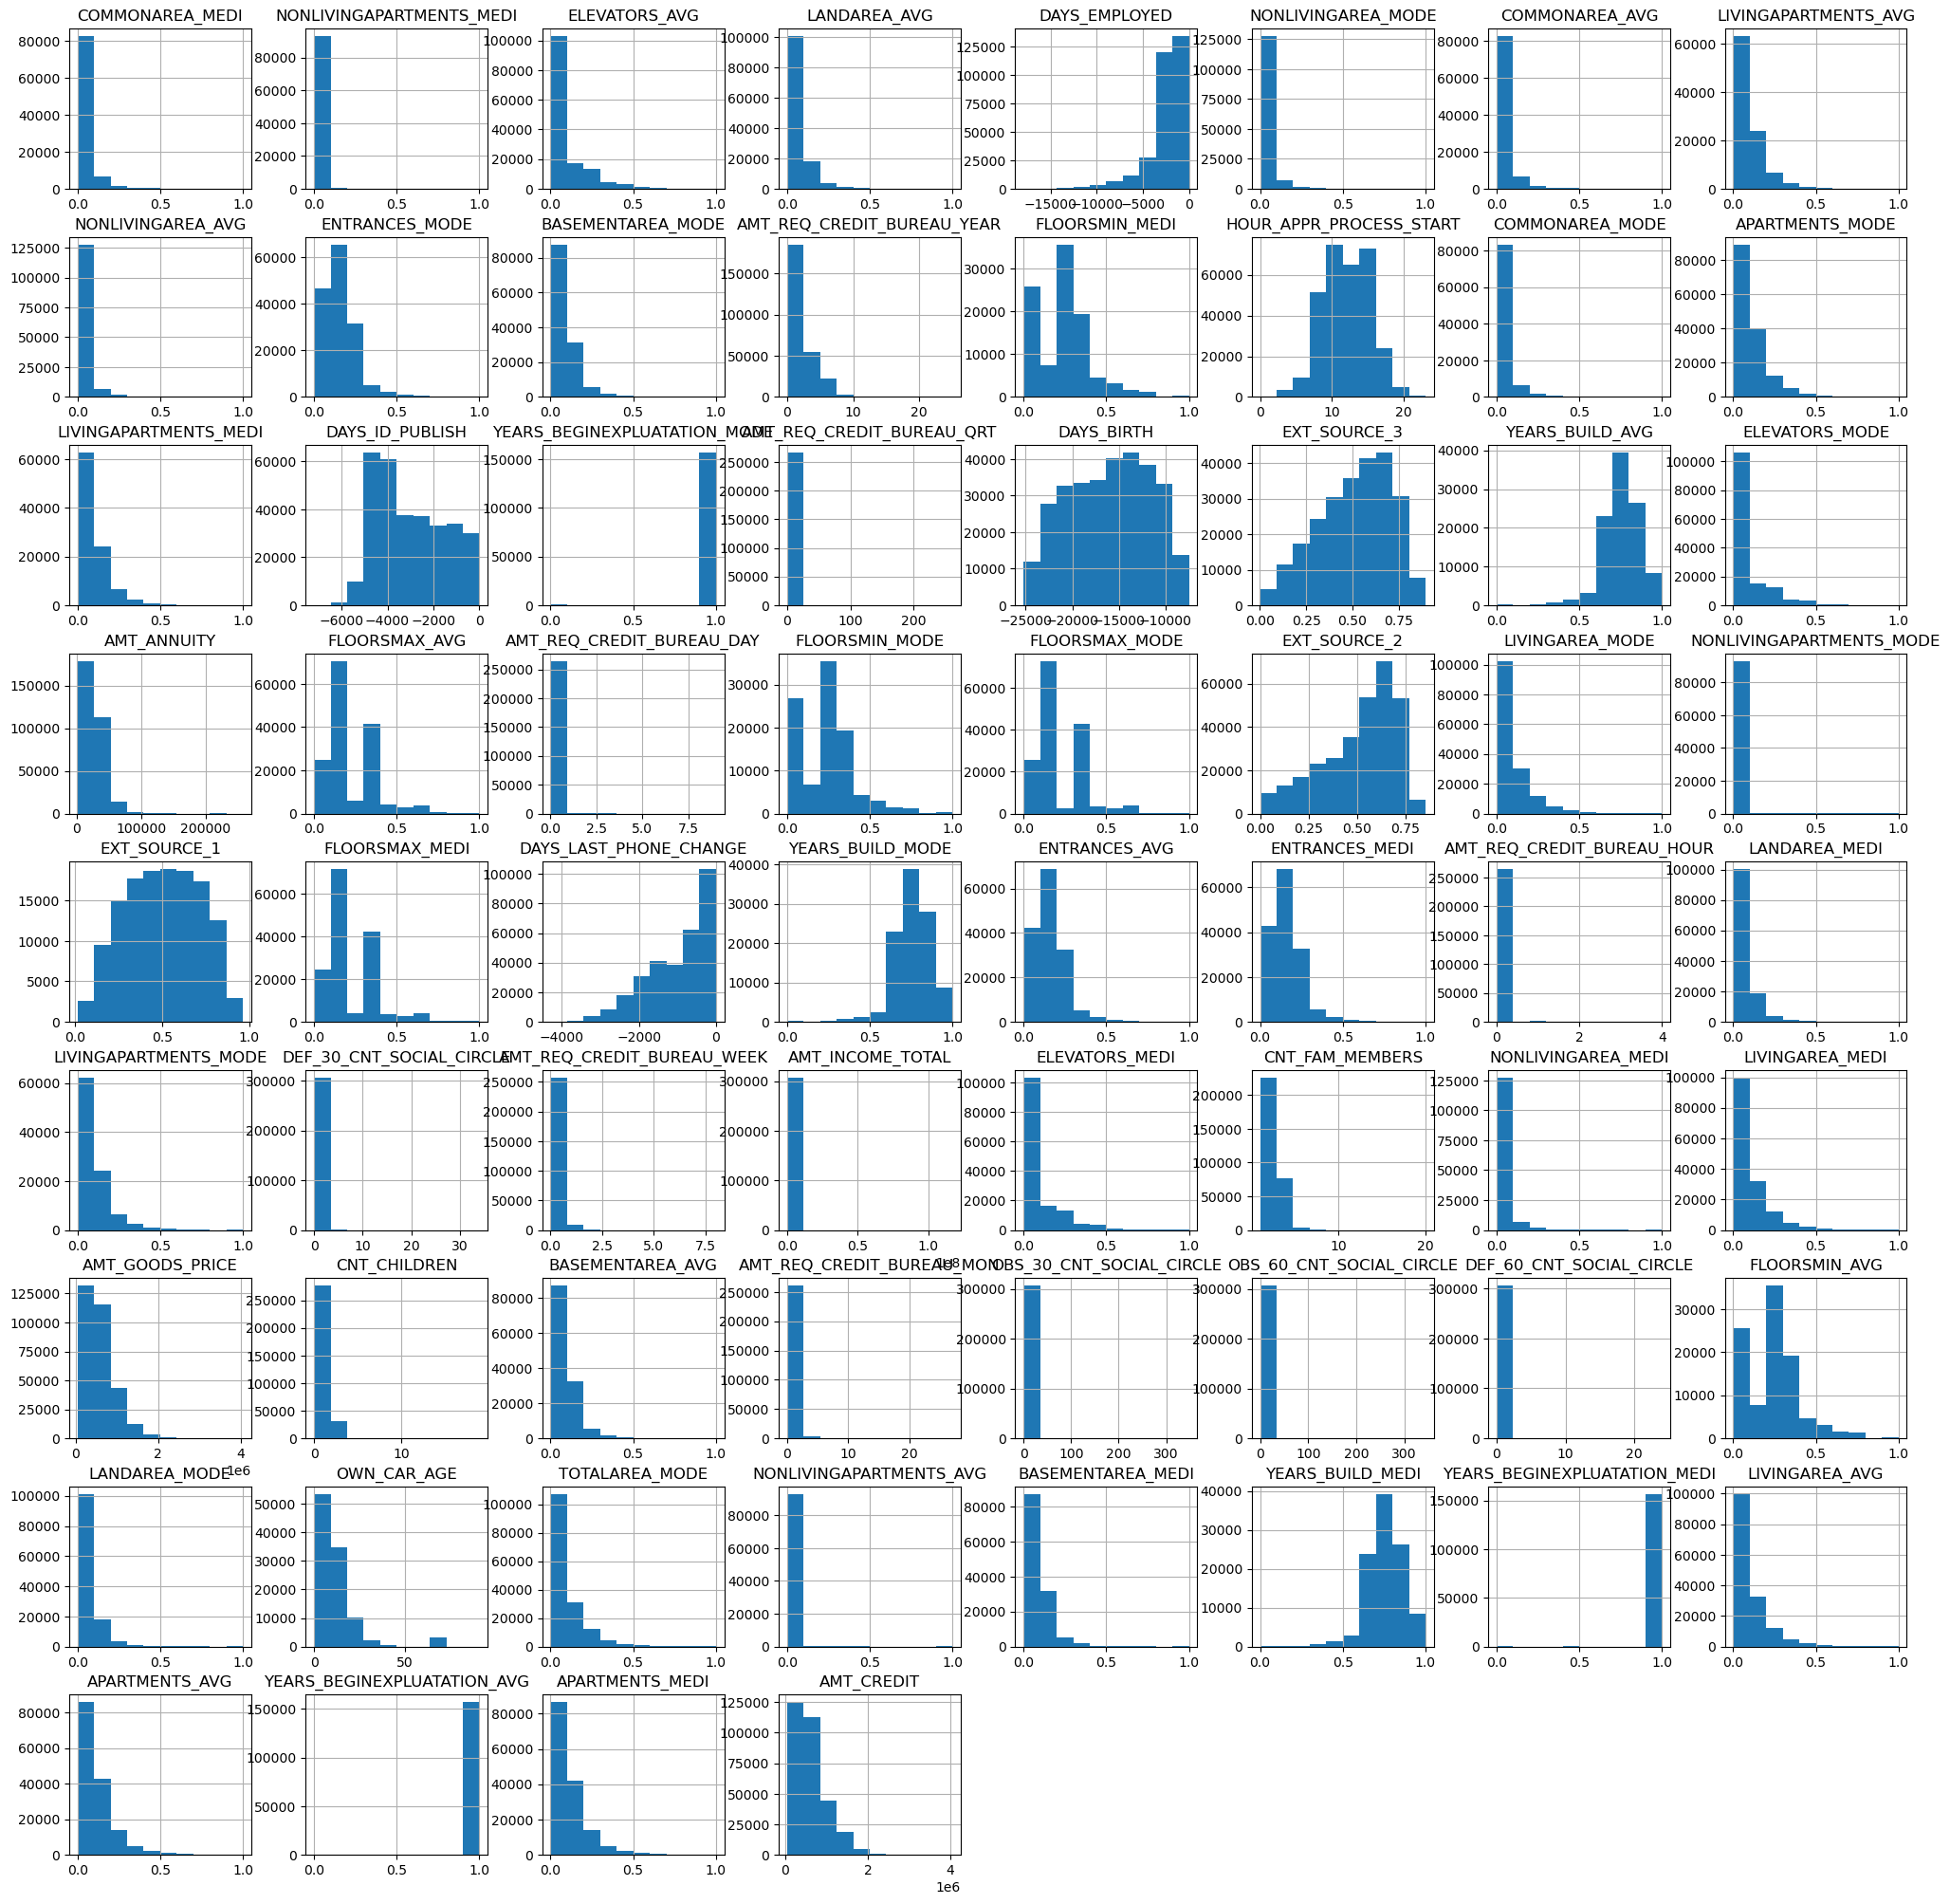

In [23]:
train_df[numerical].hist(figsize=(25, 25))
plt.show()

Тепер поглянемо на Box plot тих самих зміних

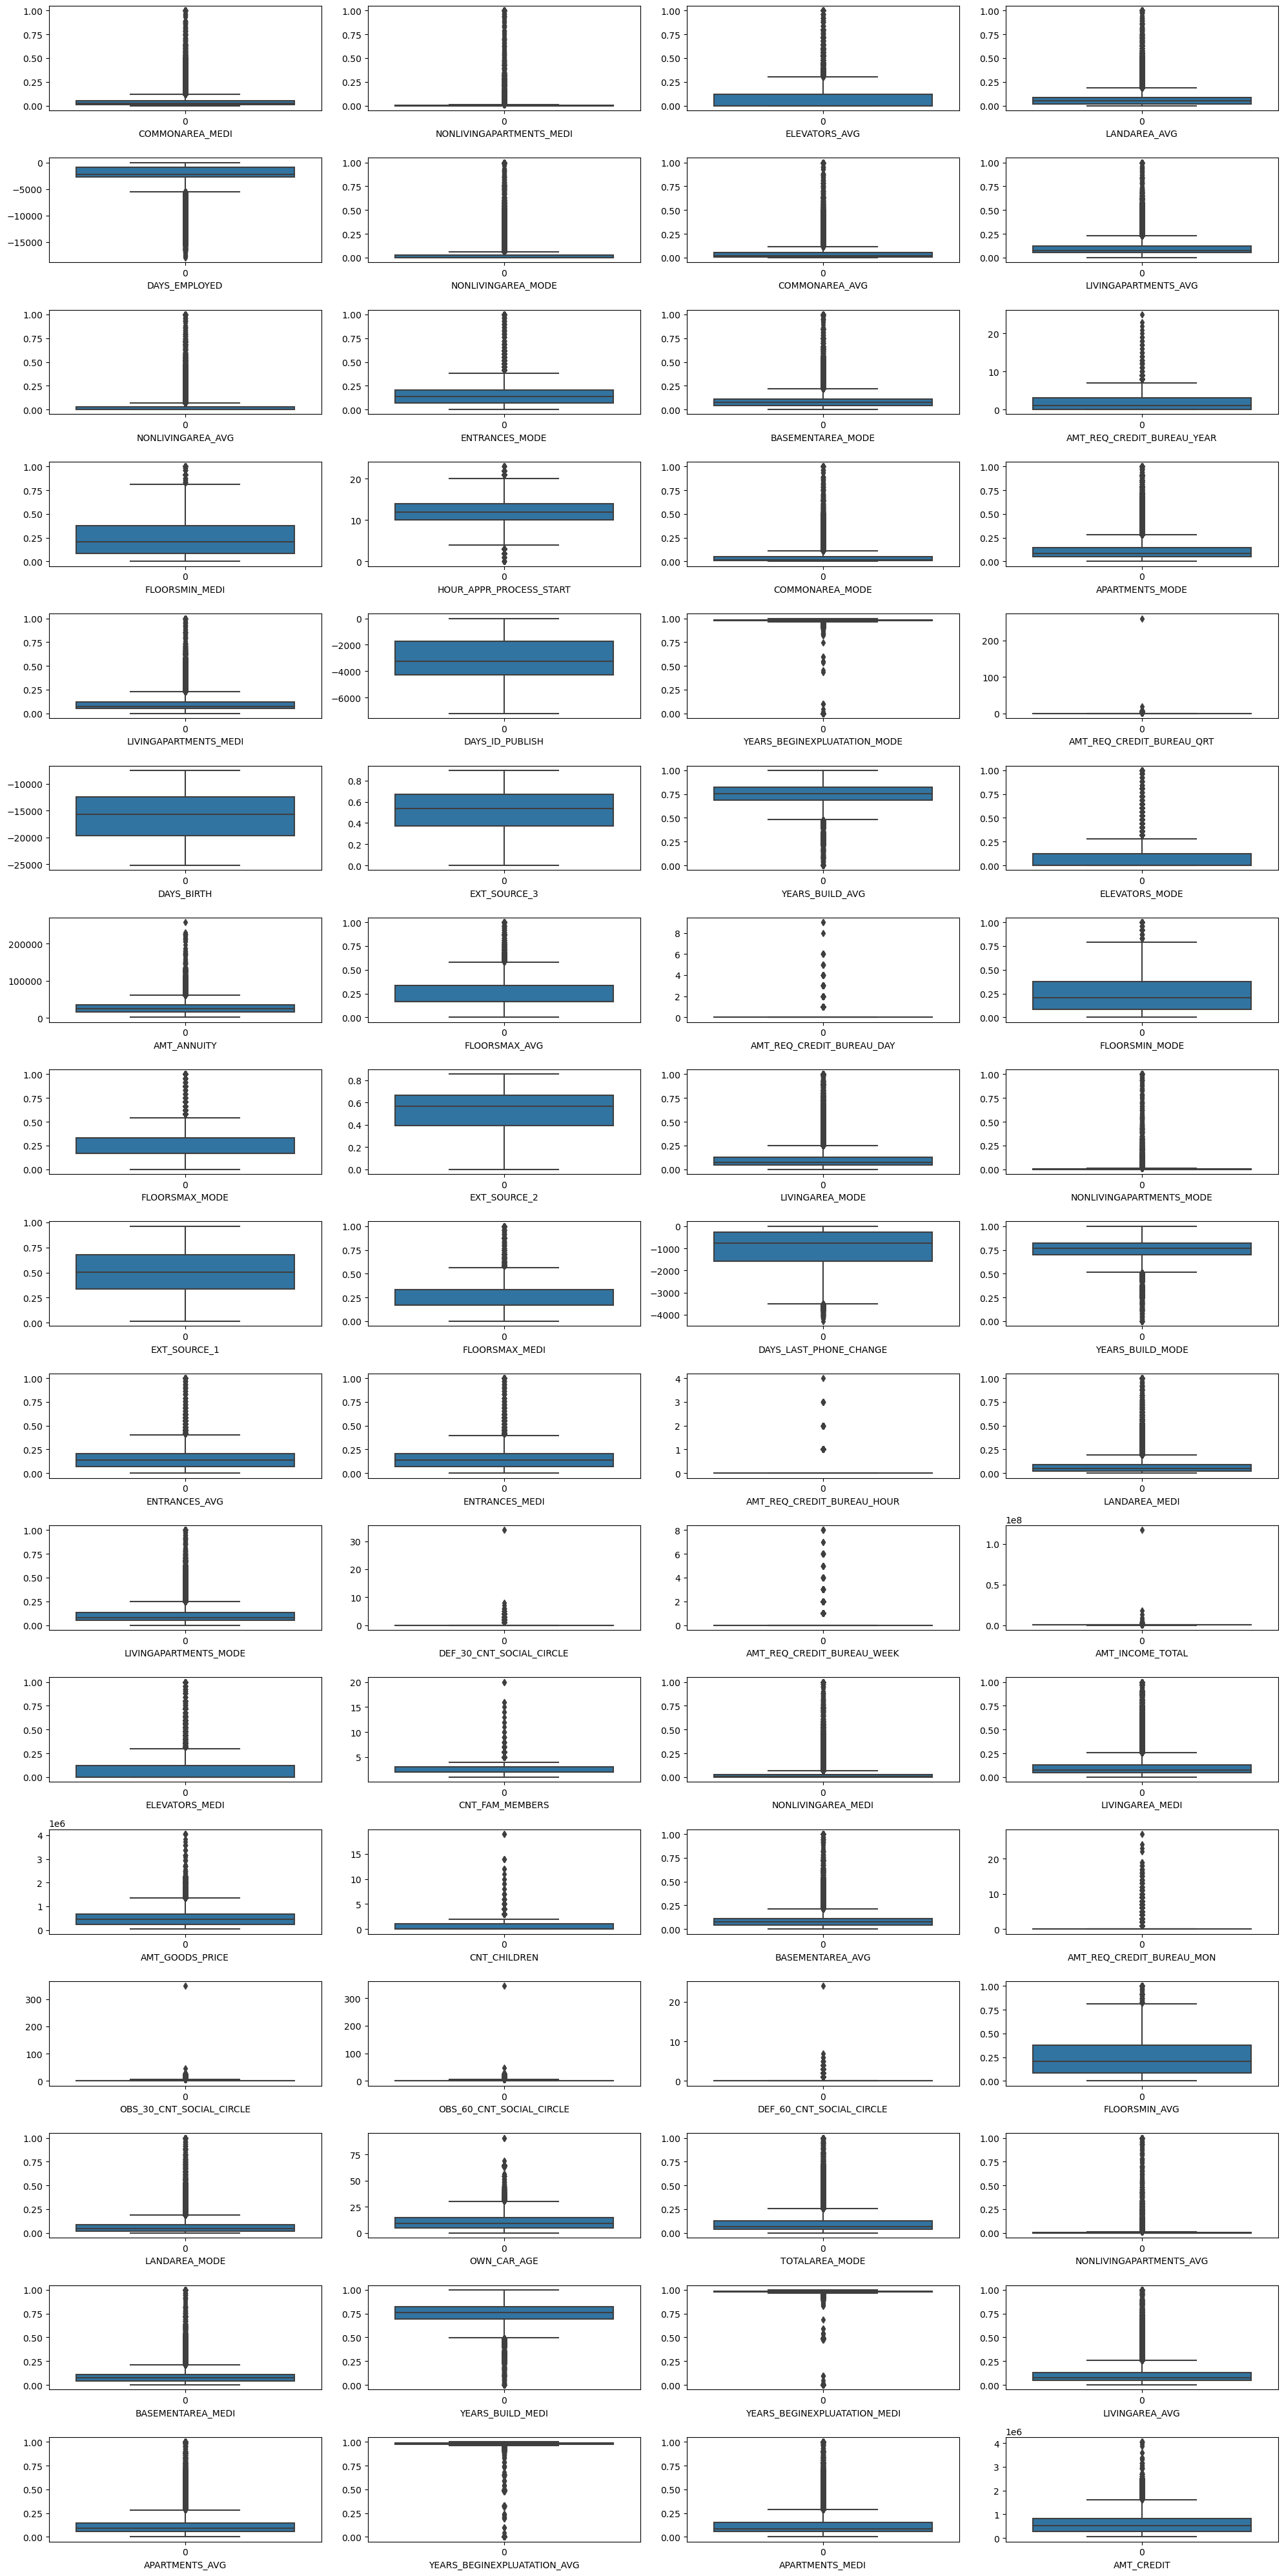

In [24]:
fig, axs = plt.subplots(figsize=(20, 40), nrows=len(numerical) // 4, ncols=4)
for i, col in enumerate(numerical):
    ax = axs[i//4, i%4]
    sns.boxplot(train_df[col], ax=ax)
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

Можна побачити, що багато колонок мають викиди, що можна зрозуміти за "вусами" графіків, отже доведеться почистити дані від них

### Підготовка даних

Створимо функції, що замінюють відсутні значення на моду для категоріальних та середнє для числових колонок, а також що вилучають викиди з чисельних колонок та замінюють їх на середнє

In [25]:
def fill_na(df_orig):
    df = df_orig.copy()
    
    for col in numerical:
        df[col].fillna(df[col].mean(), inplace=True)
    
    for col in list(set(df.columns.tolist()) - set(numerical)):
        df[col].fillna(df[col].mode(), inplace=True)
        
    return df

def balance_columns(df_orig):
    df = df_orig.copy()
    
    for col in numerical:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3-q1
        
        lower = q1 - 2 * iqr
        upper = q3 + 2 * iqr
        
        df[(df[col] < lower) | (df[col] > upper)][col] = np.nan
        df[col].fillna(df[col].mean(), inplace=True)
    
    return df

In [26]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler() 

X_train = fill_na(train_df)
X_test = fill_na(test_df)
X_train[numerical] = std_scaler.fit_transform(X_train[numerical])
X_test[numerical] = std_scaler.transform(X_test[numerical])
X_train = balance_columns(X_train)

C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] < lower) | (df[col] > upper)][col] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] < lower) | (df[col] > upper)][col] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] < lower) | (df[col] > upper)][col] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] < lower) | (df[col] > upper)][col] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] < lower) | (df[col] > upper)][col] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] < lower) | (df[col] > upper)][col] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_2080\3370387627.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [27]:
X_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,-0.577538,0.142129,-0.478095,-0.166149,-0.507465,0.018801,...,False,False,False,False,False,True,False,True,False,1
1,100003,0,0,0,-0.577538,0.426792,1.725450,0.592677,1.600698,0.003541,...,True,False,False,False,False,False,False,True,False,0
2,100004,1,1,1,-0.577538,-0.427196,-1.152888,-1.404676,-1.092389,0.010032,...,False,False,False,False,False,False,False,False,False,0
3,100006,0,0,1,-0.577538,-0.142533,-0.711430,0.177869,-0.653696,0.008019,...,False,False,False,False,False,False,False,False,False,0
4,100007,0,0,1,-0.577538,-0.199466,-0.213734,-0.361755,-0.068772,0.028663,...,False,False,False,False,False,False,False,False,False,0


In [28]:
X_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,0,1,-0.577538,-0.142533,-0.075097,-0.451796,-0.239375,0.018850,...,False,False,False,False,False,False,True,False,True,False
1,100005,0,0,1,-0.577538,-0.294354,-0.934825,-0.671930,-0.970530,0.035792,...,False,False,False,False,False,False,False,False,False,False
2,100013,0,1,1,-0.577538,0.142129,0.159601,2.943984,0.248061,0.019101,...,False,False,False,False,False,False,False,False,False,False
3,100028,0,0,1,2.192084,0.616567,2.424840,1.511714,2.807103,0.026392,...,False,False,False,False,False,True,False,False,True,False
4,100038,0,1,0,0.807273,0.047242,0.065776,0.342115,0.235875,0.010032,...,False,False,False,False,False,False,False,False,False,False


Видалимо колонку з ідентифікаторами

In [29]:
X_train.drop("SK_ID_CURR", axis=1)
X_test.drop("SK_ID_CURR", axis=1)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,0,1,-0.577538,-0.142533,-0.075097,-0.451796,-0.239375,0.018850,-0.734193,...,False,False,False,False,False,False,True,False,True,False
1,0,0,1,-0.577538,-0.294354,-0.934825,-0.671930,-0.970530,0.035792,-0.464485,...,False,False,False,False,False,False,False,False,False,False
2,0,1,1,-0.577538,0.142129,0.159601,2.943984,0.248061,0.019101,-0.916824,...,False,False,False,False,False,False,False,False,False,False
3,0,0,1,2.192084,0.616567,2.424840,1.511714,2.807103,0.026392,0.472274,...,False,False,False,False,False,True,False,False,True,False
4,0,1,0,0.807273,0.047242,0.065776,0.342115,0.235875,0.010032,0.686757,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,0,1,-0.577538,-0.199466,-0.463281,-0.664789,-0.726812,0.002042,-0.901242,...,False,False,False,False,False,False,False,False,False,False
48740,0,0,0,2.192084,-0.047646,0.058106,0.331248,-0.117516,0.035792,1.111598,...,False,False,False,False,False,False,False,False,False,False
48741,0,1,1,0.807273,0.142129,-0.705672,0.420668,-0.604953,0.026392,0.026351,...,False,False,False,False,False,False,True,False,True,False
48742,0,0,0,-0.577538,0.237017,-0.370260,-0.136653,-0.239375,0.018850,0.474107,...,False,False,False,False,False,True,False,False,True,False


Розділимо тренувальний набір даних на тренувальний та валідаційний за пропорцією 80/20 

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_train, X_val, y_train, y_val = train_test_split(X_train.drop('TARGET', axis=1), X_train['TARGET'], test_size=0.2, random_state=2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((246008, 239), (61503, 239), (246008,), (61503,), (48744, 239))

### Тренування моделі, її оцінка

У якості класифікатора було обрано RandomForestClassifier, що є випадковим ансамблем дерев та навчимо її на тренувальних даних

In [31]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2, verbose=1, class_weight='balanced', n_jobs=-1)
random_forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.6s finished


RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1,
                       random_state=2, verbose=1)

Визначимо наскільки точною є модель за допомогою roc_auc_score на валідаційному наборі даних

In [32]:
y_pred = random_forest.predict_proba(X_val)[:, 1]
print(roc_auc_score(y_val, y_pred))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


0.7131535674955546


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished


### Фінальна відповідь

Тепер зробимо розрахунки ймовірностей моделі для тестових даних та збережемо датафрейм у форматі csv

In [33]:
submission = pd.DataFrame(test_df['SK_ID_CURR'])
submission_preds = random_forest.predict_proba(X_test)[:, 1]
submission['TARGET'] = submission_preds
submission.head()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


,SK_ID_CURR,TARGET
0,100001,0.416972
1,100005,0.500772
2,100013,0.392688
3,100028,0.364077
4,100038,0.566539


In [34]:
submission.to_csv('submission.csv', index=False)

Після завантаження відповіді отримали оцінку точності моделі на рівні 70-71% 

<img src="./result_submission.png">